# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [19]:
%matplotlib inline

In [20]:
from __future__ import print_function

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [22]:
import ilqr
from ilqr import iLQR
from ilqr.cost import QRCost
from ilqr.dynamics import constrain
from ilqr.examples.cartpole import CartpoleDynamics

In [23]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = dynamics.reduce_state(xs[-1])
    print("iteration", iteration_count, info, J_opt, final_state)

In [24]:
dt = 0.05
pole_length = 1.0
dynamics = CartpoleDynamics(dt, l=pole_length)

In [25]:
# Note that the augmented state is not all 0.
x_goal = dynamics.augment_state(np.array([0.0, 0.0, 0.0, 0.0]))

# Instantenous state cost.
Q = np.eye(dynamics.state_size)
Q[0, 0] = 1.0
Q[1, 1] = Q[4, 4] = 0.0
Q[0, 2] = Q[2, 0] = pole_length
Q[2, 2] = Q[3, 3] = pole_length**2
R = 0.1 * np.eye(dynamics.action_size)

# Terminal state cost.
Q_terminal = 100 * np.eye(dynamics.state_size)

# Instantaneous control cost.
R = np.array([[0.1]])

cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [26]:
N = 100
x0 = dynamics.augment_state(np.array([0.0, 0.0, np.pi, 0.0]))
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost, N)

In [27]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=500, on_iteration=on_iteration)

(101, 5) (100, 5, 5) (100, 5, 1) (101,) (101, 5) (100, 1) (101, 5, 5) (100, 1, 5) (100, 1, 1)
iteration 0 accepted 800.0599963969444 [ 4.87067904e-03 -2.66426098e-03 -3.13064573e+00 -1.00739267e-02]
(101, 5) (100, 5, 5) (100, 5, 1) (101,) (101, 5) (100, 1) (101, 5, 5) (100, 1, 5) (100, 1, 1)
iteration 1 accepted 799.9514488909707 [-1.35624845e-04  6.95076734e-04 -3.12038665e+00 -1.39833714e-03]
(101, 5) (100, 5, 5) (100, 5, 1) (101,) (101, 5) (100, 1) (101, 5, 5) (100, 1, 5) (100, 1, 1)
iteration 2 accepted 799.8047444745318 [ 7.75897838e-04  5.34675800e-04 -3.09999304e+00 -5.74696545e-04]
(101, 5) (100, 5, 5) (100, 5, 1) (101,) (101, 5) (100, 1) (101, 5, 5) (100, 1, 5) (100, 1, 1)
iteration 3 accepted 799.2510050867153 [ 1.91385763e-03  7.45675873e-04 -3.06009129e+00 -2.41651055e-04]
(101, 5) (100, 5, 5) (100, 5, 1) (101,) (101, 5) (100, 1) (101, 5, 5) (100, 1, 5) (100, 1, 1)
iteration 4 accepted 797.1404797111561 [ 4.05411113e-03  1.12348677e-03 -2.98214335e+00  3.59559305e-04]
(101,

In [10]:
# Reduce the state to something more reasonable.
print(xs.shape)
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

(11, 5)


In [11]:
print(xs.shape)
t = np.arange(N + 1) * dt
x = xs[:, 0]
x_dot = xs[:, 1]
theta = np.unwrap(xs[:, 2])  # Makes for smoother plots.
theta_dot = xs[:, 3]

(11, 4)


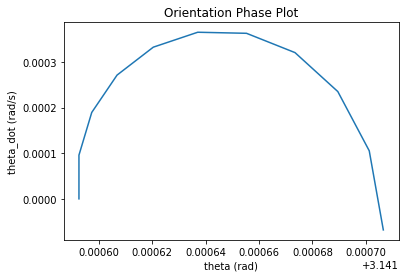

In [12]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")

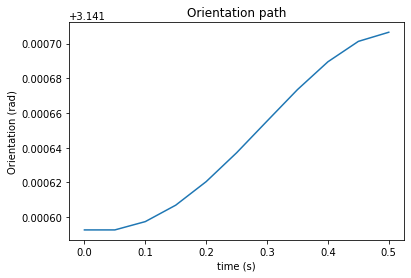

In [13]:
_ = plt.plot(t, theta)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Orientation (rad)")
_ = plt.title("Orientation path")

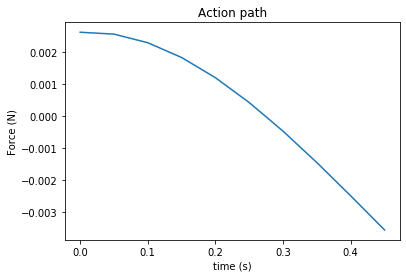

In [14]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

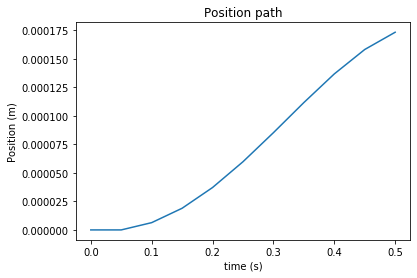

In [15]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

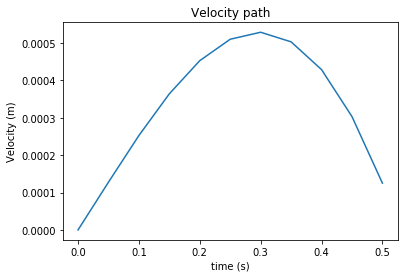

In [16]:
_ = plt.plot(t, x_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Velocity (m)")
_ = plt.title("Velocity path")

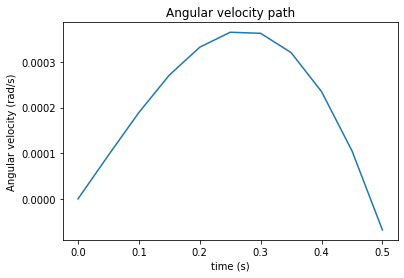

In [17]:
_ = plt.plot(t, theta_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Angular velocity (rad/s)")
_ = plt.title("Angular velocity path")

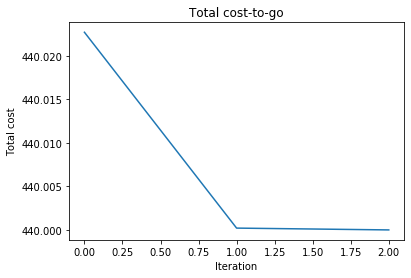

In [18]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")